There are three general cases where we want to construct a scheduler to make observations:

1) We have a large area we would like to observe (in one or more filters) in an intelligent way.  In this case, we typically define a survey footprint with HEALpix maps and use one or more `BlobSurvey` objects to execute the observations. This is how we execute the main LSST survey, including things like the Wide Fast Deep area and the North Ecliptic Spur. 
2) We have a list of pointings we would like executed at a specific time. This case can be done with `ScriptedSurvey` objects. 
3) We would like to select the best choice from a list of potential pointings. This doesn't come up for the main LSST survey, but can be useful for AuxTel and commissioning studies.  

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pylab as plt
%matplotlib inline
import pandas as pd

from rubin_scheduler.scheduler import sim_runner
from rubin_scheduler.scheduler.model_observatory import ModelObservatory
from rubin_scheduler.scheduler.surveys import PointingsSurvey
from rubin_scheduler.scheduler.utils import ObservationArray
from rubin_scheduler.scheduler.schedulers import CoreScheduler

from astropy import units
from astropy.coordinates import Angle

import pickle

In [2]:
# Read in a list of pointings we might want to observe
tiles = pd.read_csv('auxtel_tiles.txt', delimiter=' ')
tiles

,Survey,Name,RA,Dec
0,LATISS_POLE,001,00:00:00.00,-89:53:48.23
1,LATISS_POLE,002,02:10:54.54,-89:53:48.23
2,LATISS_POLE,003,04:21:49.09,-89:53:48.23
3,LATISS_POLE,004,06:32:43.63,-89:53:48.23
4,LATISS_POLE,005,08:43:38.18,-89:53:48.23
...,...,...,...,...
794,AUXTEL_PHOTO_IMAGING,Photo1800-1_028,18:00:46.04,-24:57:20.25
795,AUXTEL_PHOTO_IMAGING,Photo1800-1_029,18:00:49.96,-24:57:20.25
796,AUXTEL_PHOTO_IMAGING,Photo1800-1_030,18:00:53.88,-24:57:20.25
797,AUXTEL_PHOTO_IMAGING,Photo1800-1_031,18:00:57.79,-24:57:20.25


In [3]:
# Convert pointings to an observation array
obs = ObservationArray(n=len(tiles))
obs['scheduler_note'] = tiles['Survey'] + tiles['Name']
obs['RA'] = Angle(tiles['RA'],unit=units.hourangle).rad
obs['dec'] = Angle(tiles['Dec'],unit=units.degree).rad

obs['flush_by_mjd'] = 0.
obs['nexp'] = 1
obs['filter'] = 'r'
obs['exptime'] = 60.

In [4]:
# load the potential observations into a PointingsSurvey
# by default, the PointingsSurvey will stick on a detailer that 
# sets each observation to the parallactic angle. For now we'll clobber 
# that so all the observations get taken with rotTelPos=0
ps = PointingsSurvey(obs, detailers=[])
sched = CoreScheduler([ps])


In [5]:
# Try observing with the survey for 3 days
mo = ModelObservatory(downtimes="ideal")
mo, sched, completed_obs = sim_runner(mo, sched, sim_duration=3)


/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/surveys/pointings_survey.py:268: RuntimeWarning: invalid value encountered in divide
  result = np.floor(1.0 + self.n_obs / sum_obs)


progress = 65.27%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:352: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


progress = 99.98%Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 1877 observations
ran in 0 min = 0.0 hours


Text(0.5, 1.0, 'Completed observations')

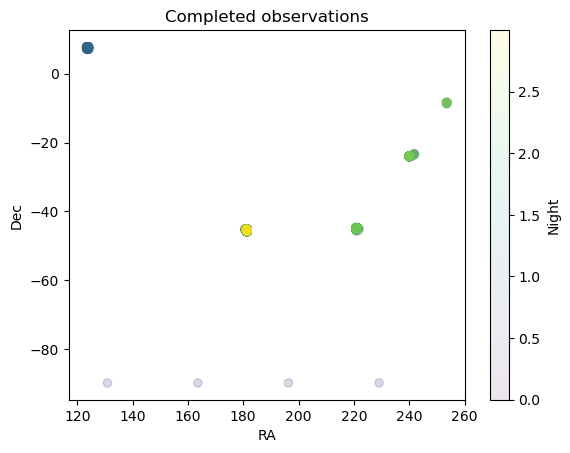

In [6]:
# plot the observations that were taken
fig, ax = plt.subplots()
ack = ax.scatter(np.degrees(completed_obs['RA']), np.degrees(completed_obs['dec']),
            c=completed_obs['mjd']-completed_obs['mjd'].min(), alpha=0.1)
cb = plt.colorbar(ack)
cb.set_label('Night')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.set_title('Completed observations')

In [7]:
conditions = mo.return_conditions()
conditions

Conditions at 0x3041a2e90
============================
nside:  32   
site:  LSST   
exptime:  30.0   
lmst:  [10.09478658]   
clouds:  None   
current_filter:  r   
mounted_filters:  ['g', 'r', 'i', 'z', 'y']   
night:  3   
wind_speed:  None   
wind_direction:  None   
len(scheduled_observations):  0   
len(queue):  None   
moonPhase:  45.903710925335766   
bulk_cloud:  [0.]   
targets_of_opportunity:  None   
cumulative_azimuth_rad:  [2.20400493]   

Positions (radians)
-------------------
| name      |        alt |        az |       RA |       decl |   rot |
|:----------|-----------:|----------:|---------:|-----------:|------:|
| sun       |  -0.437797 | nan       | 0.715277 |  0.27698   |   nan |
| moon      |   0.573293 |   5.87194 | 2.26262  |  0.404406  |   nan |
| venus     | nan        | nan       | 4.32439  | -0.374159  |   nan |
| mars      | nan        | nan       | 2.89319  |  0.138134  |   nan |
| jupiter   | nan        | nan       | 1.54546  |  0.404308  |   nan |
| saturn    | nan        | nan       | 6.19314  | -0.0798694 |   nan |
| telescope |   1.08287  |   2.29125 | 3.16376  | -0.792473  |     0 |

Positions (degrees)
-------------------
| name      |      alt |      az |       RA |      decl |   rot |
|:----------|---------:|--------:|---------:|----------:|------:|
| sun       | -25.0839 | nan     |  40.9823 |  15.8698  |   nan |
| moon      |  32.8473 | 336.437 | 129.639  |  23.1708  |   nan |
| venus     | nan      | nan     | 247.769  | -21.4378  |   nan |
| mars      | nan      | nan     | 165.767  |   7.91451 |   nan |
| jupiter   | nan      | nan     |  88.5482 |  23.1651  |   nan |
| saturn    | nan      | nan     | 354.841  |  -4.57618 |   nan |
| telescope |  62.0439 | 131.279 | 181.27   | -45.4053  |     0 |

Events
------
| event           |     MJD | date                          |
|:----------------|--------:|:------------------------------|
| sunset          | 60798.9 | 2025-05-03 22:01:24.180378913 |
| sun_n12_setting | 60799   | 2025-05-03 22:58:56.840710042 |
| sun_n18_setting | 60799   | 2025-05-03 23:27:08.767199813 |
| mjd             | 60799   | 2025-05-04 00:00:08.862715958 |
| moonset         | 60799.2 | 2025-05-04 03:44:58.853677511 |
| sun_n18_rising  | 60799.4 | 2025-05-04 09:52:40.349746044 |
| sun_n12_rising  | 60799.4 | 2025-05-04 10:20:54.727278648 |
| sunrise         | 60799.5 | 2025-05-04 11:18:33.493913412 |
| moonrise        | 60799.8 | 2025-05-04 18:02:53.684754964 |

Maps
----
| map             |   nside |       min |        max |   median |
|:----------------|--------:|----------:|-----------:|---------:|
| airmass         |      32 |  1.00011  | 2023.39    |  1.99986 |
| ra              |      32 |  0        |    6.25864 |  3.12932 |
| dec             |      32 | -1.54528  |    1.54528 |  0       |
| slewtime        |      32 |  4.02758  |  155.97    | 87.8253  |
| m5_depth_u      |      32 | 21.641    |   23.4351  | 22.9119  |
| m5_depth_g      |      32 | 22.7408   |   24.5751  | 24.068   |
| m5_depth_r      |      32 | 22.7132   |   24.4004  | 23.9248  |
| m5_depth_i      |      32 | 22.5993   |   24.0901  | 23.6323  |
| m5_depth_z      |      32 | 22.2565   |   23.5454  | 23.1085  |
| m5_depth_y      |      32 | 21.2968   |   22.614   | 22.1473  |
| skybrightness_u |      32 | 20.2512   |   21.8022  | 21.4947  |
| skybrightness_g |      32 | 19.1271   |   21.2938  | 20.8658  |
| skybrightness_r |      32 | 18.7849   |   20.8594  | 20.4332  |
| skybrightness_i |      32 | 18.6028   |   20.2587  | 19.8609  |
| skybrightness_z |      32 | 18.2143   |   19.4469  | 19.0707  |
| skybrightness_y |      32 | 17.6182   |   18.6018  | 18.2513  |
| fwhm_eff_u      |      32 |  0.866154 |    3.73443 |  1.24897 |
| fwhm_eff_g      |      32 |  0.820989 |    3.5397  |  1.18384 |
| fwhm_eff_r      |      32 |  0.779768 |    3.36198 |  1.1244  |
| fwhm_eff_i      |      32 |  0.751378 |    3.23958 |  1.08346 |
| fwhm_eff_z      |      32 |  0.732565 |    3.15846 |  1.05634 |
| fwhm_eff_y      |      32 |  0.717519 |    3.09359 |  1.03464 |


In [8]:
# What does the scheduler look like
sched

# CoreScheduler at 0x1788ed6d0
|              | value                            |
|:-------------|:---------------------------------|
| camera       | LSST                             |
| nside        | 32                               |
| survey index | [0, 0]                           |
| Last chosen  | <PointingsSurvey at 0x1789b6e90> |

## Surveys

### Survey list 0
| survey                           |   reward | chosen   |
|:---------------------------------|---------:|:---------|
| <PointingsSurvey at 0x1789b6e90> | -3.25957 | True     |

Conditions at 0x178a015d0
============================
nside:  32   
site:  LSST   
exptime:  30.0   
lmst:  [10.07676106]   
clouds:  None   
current_filter:  r   
mounted_filters:  ['g', 'r', 'i', 'z', 'y']   
night:  3   
wind_speed:  None   
wind_direction:  None   
len(scheduled_observations):  0   
len(queue):  0   
moonPhase:  45.900517715105885   
bulk_cloud:  [0.]   
targets_of_opportunity:  None   
cumulative_azimuth_rad:  [2.20400493]   

Positions (radians)
-------------------
| name      |       alt |        az |       RA |       decl |   rot |
|:----------|----------:|----------:|---------:|-----------:|------:|
| sun       |  -0.43375 | nan       | 0.715264 |  0.276976  |   nan |
| moon      |   0.57481 |   5.87663 | 2.26251  |  0.40447   |   nan |
| venus     | nan       | nan       | 4.32437  | -0.374155  |   nan |
| mars      | nan       | nan       | 2.89318  |  0.138137  |   nan |
| jupiter   | nan       | nan       | 1.54546  |  0.404308  |   nan |
| saturn    | nan       | nan       | 6.19314  | -0.0798696 |   nan |
| telescope |   1.08258 |   2.28339 | 3.1614   | -0.789168  |     0 |

Positions (degrees)
-------------------
| name      |      alt |      az |       RA |      decl |   rot |
|:----------|---------:|--------:|---------:|----------:|------:|
| sun       | -24.852  | nan     |  40.9816 |  15.8695  |   nan |
| moon      |  32.9342 | 336.706 | 129.632  |  23.1744  |   nan |
| venus     | nan      | nan     | 247.768  | -21.4375  |   nan |
| mars      | nan      | nan     | 165.767  |   7.91464 |   nan |
| jupiter   | nan      | nan     |  88.5481 |  23.1651  |   nan |
| saturn    | nan      | nan     | 354.841  |  -4.57619 |   nan |
| telescope |  62.0272 | 130.829 | 181.135  | -45.216   |     0 |

Events
------
| event           |     MJD | date                          |
|:----------------|--------:|:------------------------------|
| sunset          | 60798.9 | 2025-05-03 22:01:24.180378913 |
| sun_n12_setting | 60799   | 2025-05-03 22:58:56.840710042 |
| sun_n18_setting | 60799   | 2025-05-03 23:27:08.767199813 |
| mjd             | 60799   | 2025-05-03 23:59:04.148039820 |
| moonset         | 60799.2 | 2025-05-04 03:44:58.853677511 |
| sun_n18_rising  | 60799.4 | 2025-05-04 09:52:40.349746044 |
| sun_n12_rising  | 60799.4 | 2025-05-04 10:20:54.727278648 |
| sunrise         | 60799.5 | 2025-05-04 11:18:33.493913412 |
| moonrise        | 60799.8 | 2025-05-04 18:02:53.684754964 |

Maps
----
| map             |   nside |       min |         max |   median |
|:----------------|--------:|----------:|------------:|---------:|
| airmass         |      32 |  1.00006  | 21866.5     |  2.00084 |
| ra              |      32 |  0        |     6.25864 |  3.12932 |
| dec             |      32 | -1.54528  |     1.54528 |  0       |
| slewtime        |      32 |  3.90365  |   155.962   | 88.1657  |
| m5_depth_u      |      32 | 21.6466   |    23.4348  | 22.9122  |
| m5_depth_g      |      32 | 22.7445   |    24.5747  | 24.0647  |
| m5_depth_r      |      32 | 22.7164   |    24.4002  | 23.9238  |
| m5_depth_i      |      32 | 22.6028   |    24.0898  | 23.6318  |
| m5_depth_z      |      32 | 22.2604   |    23.5453  | 23.1088  |
| m5_depth_y      |      32 | 21.3019   |    22.614   | 22.1475  |
| skybrightness_u |      32 | 20.2563   |    21.8017  | 21.4938  |
| skybrightness_g |      32 | 19.1335   |    21.2936  | 20.8641  |
| skybrightness_r |      32 | 18.7893   |    20.8589  | 20.4336  |
| skybrightness_i |      32 | 18.6063   |    20.2585  | 19.8606  |
| skybrightness_z |      32 | 18.2161   |    19.4467  | 19.0711  |
| skybrightness_y |      32 | 17.6207   |    18.6017  | 18.2509  |
| fwhm_eff_u      |      32 |  0.866154 |     3.73443 |  1.24897 |
| fwhm_eff_g      |      32 |  0.820989 |     3.5397  |  1.18384 |
| fwhm_eff_r      |      32 |  0.779768 |     3.36198 |  1.1244  |
| fwhm_eff_i      |      32 |  0.751378 |     3.23958 |  1.08346 |
| fwhm_eff_z      |      32 |  0.732565 |     3.15846 |  1.05634 |
| fwhm_eff_y      |      32 |  0.717519 |     3.09359 |  1.03464 |


## Queue
Queue is empty


In [9]:
# output a pretty table showing the current status of the survey. 
# This is a stubb in place so things should be easy to pass to schedview
conditions = mo.return_conditions()
sched.survey_lists[0][0].make_reward_df(conditions)

,method,blank,feasible,max_reward,n_possibles,weight,max_accum_reward,accum_n
0,visit_gap,None,True,0.0,776,1.0,0.000000,776
1,balance_revisit,None,True,1.0,799,1.0,1.000000,776
2,m5diff,None,True,-0.138504,313,1.0,0.861496,290
3,slew_time,None,True,-4.099342,313,-1.0,-3.319316,290
4,wind_limit,None,True,0.0,799,0.0,-3.319316,290
5,ha_limit,None,True,0.0,132,0.0,-3.319316,109
6,alt_limit,None,True,0.0,313,0.0,-3.319316,109
7,moon_limit,None,True,0.0,735,0.0,-3.319316,45


Text(0, 0.5, 'Dec')

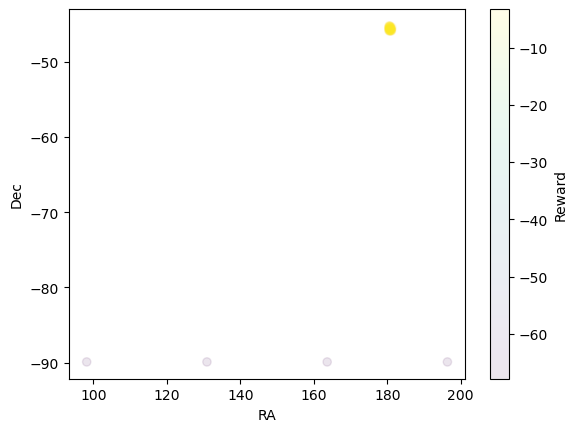

In [10]:
# can look at the reward for each potential observations on the sky
fig, ax = plt.subplots()
ack = ax.scatter(np.degrees(sched.survey_lists[0][0].observations['RA']),
            np.degrees(sched.survey_lists[0][0].observations['dec']),
            c=sched.survey_lists[0][0].reward, alpha=0.1)
cb = plt.colorbar(ack)
cb.set_label('Reward')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')

In [11]:
# How big is it to dump this scheduler
file = open('save_test.pkl', 'wb')
pickle.dump(sched, file)
file.close()
from subprocess import Popen
Popen('ls -lh *.pkl', shell=True)

<Popen: returncode: None args: 'ls -lh *.pkl'>

Pros and cons

Cons:

* Not as modular as using basis function objects
* Setting an altitude limit of observations taken by a `PointingSurvey` object is done differently than in a `BlobSurvey`. (but we have the same issue with `ScriptedSurveys` where the logic on when to execute doesn't use only basis functions.)

Pros

* Scalable. 1 to 1,000,000 potential pointings, no problem. No looping over many survey objects.
* Small memory/storage footprint. 3M uncompressed, <1M compressed. Current Auxtel uncompressed is 157M
* Easy to output debugging data frame analagous to the other surveys
* Easier to configure since all the logic is already in the class. One-liner to make the survey class

## Example removing the 5-sigma depth logic in making decisions on what to observe

In [12]:
# Say we want to lift the m5 and moon limits. Just remove them from the weights dict
weights = {"visit_gap": 1.0, "balance_revisit": 1.0,  "slew_time": -1.0,
           "wind_limit": 0.0, "ha_limit": 0, "alt_limit": 0}
ps = PointingsSurvey(obs, detailers=[], weights=weights)
sched = CoreScheduler([ps])

-rw-r--r--  1 yoachim  staff   4.2M Oct  8 16:58 save_test.pkl


In [13]:
mo = ModelObservatory(downtimes="ideal")
mo, sched, completed_obs = sim_runner(mo, sched, sim_duration=3)

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/surveys/pointings_survey.py:268: RuntimeWarning: invalid value encountered in divide
  result = np.floor(1.0 + self.n_obs / sum_obs)


progress = 65.27%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:352: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


progress = 99.98%Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 1876 observations
ran in 0 min = 0.0 hours


In [14]:
conditions = mo.return_conditions()
sched.survey_lists[0][0].make_reward_df(conditions)

,method,blank,feasible,max_reward,n_possibles,weight,max_accum_reward,accum_n
0,visit_gap,None,True,0.0,776,1.0,0.000000,776
1,balance_revisit,None,True,1.0,799,1.0,1.000000,776
2,slew_time,None,True,-4.191563,313,-1.0,-3.208896,290
3,wind_limit,None,True,0.0,799,0.0,-3.208896,290
4,ha_limit,None,True,0.0,132,0.0,-3.208896,109
5,alt_limit,None,True,0.0,313,0.0,-3.208896,109


## Example using Sequence Boost

In [15]:
# Let's try out the sequence boost
obs_boost = obs.copy()

# Say we want to make sure all 4 of seq1 execute, and all 5 in seq2 execute
sequence_boost = {'seq1': 4, 'seq2': 5}
weights = {"visit_gap": 1.0, "balance_revisit": 1.0,  "slew_time": -1.0,
           "wind_limit": 0.0, "ha_limit": 0, "alt_limit": 0, 'sequence_boost': 5.}

# Change the note so scheduler can recognize things as belonging to the same sequence
for i in np.arange(4):
    match = np.where(obs['scheduler_note'] == 'AUXTEL_PHOTO_IMAGINGPhoto1600-1_00%i' % (i+1))[0]
    obs_boost['scheduler_note'][match] = 'seq1_%i' % i

# and say we always want to take 5 of this one in a sequence. Need to give each part of 
# the sequence it's own observation.
match = np.where(obs['scheduler_note'] == 'AUXTEL_PHOTO_IMAGINGPhoto1600-1_020')[0]

five_obs = ObservationArray(5)
for key in five_obs.dtype.names:
    five_obs[key] = obs[match][key].copy()
for i in range(5):
    five_obs[i]["scheduler_note"] = "seq2_%i" % i

obs_boost = np.hstack([obs_boost, five_obs])

# Here we've used the sequence boost to try and make things be taken in sequences.
# One could also imagine making a detailer that makes sure every time a pointing is selected,
# it gets converted into the desired sequence. 


In [16]:
ps = PointingsSurvey(obs_boost, detailers=[], weights=weights, track_notes_ngoal=sequence_boost)
sched = CoreScheduler([ps])

mo = ModelObservatory(downtimes="ideal")
mo, sched, completed_obs = sim_runner(mo, sched, sim_duration=3)


/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/surveys/pointings_survey.py:268: RuntimeWarning: invalid value encountered in divide
  result = np.floor(1.0 + self.n_obs / sum_obs)


progress = 65.27%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:352: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


progress = 99.98%Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 1876 observations
ran in 0 min = 0.0 hours


In [17]:
conditions = mo.return_conditions()
sched.survey_lists[0][0].make_reward_df(conditions)

,method,blank,feasible,max_reward,n_possibles,weight,max_accum_reward,accum_n
0,visit_gap,None,True,0.000000,781,1.0,0.000000,781
1,balance_revisit,None,True,1.000000,804,1.0,1.000000,781
2,slew_time,None,True,-4.191563,313,-1.0,-3.208896,290
3,wind_limit,None,True,0.000000,804,0.0,-3.208896,290
4,ha_limit,None,True,0.000000,132,0.0,-3.208896,109
5,alt_limit,None,True,0.000000,313,0.0,-3.208896,109
6,sequence_boost,None,True,0.000000,804,5.0,-3.208896,109


In [18]:
# Let's see how the sequences look.
seq_indx = ['seq' in s for s in completed_obs["scheduler_note"]]
df = pd.DataFrame(completed_obs[seq_indx])


In [19]:
# does something different happen with no sequence boost?
weights = {"visit_gap": 1.0, "balance_revisit": 1.0,  "slew_time": -1.0,
           "wind_limit": 0.0, "ha_limit": 0, "alt_limit": 0.}
ps = PointingsSurvey(obs, detailers=[], weights=weights)
sched = CoreScheduler([ps])

mo = ModelObservatory(downtimes="ideal")
mo, sched, completed_obs2 = sim_runner(mo, sched, sim_duration=3)

conditions = mo.return_conditions()
sched.survey_lists[0][0].make_reward_df(conditions)

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/surveys/pointings_survey.py:268: RuntimeWarning: invalid value encountered in divide
  result = np.floor(1.0 + self.n_obs / sum_obs)


progress = 65.27%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:352: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


progress = 99.98%Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 1876 observations
ran in 0 min = 0.0 hours


,method,blank,feasible,max_reward,n_possibles,weight,max_accum_reward,accum_n
0,visit_gap,None,True,0.0,776,1.0,0.000000,776
1,balance_revisit,None,True,1.0,799,1.0,1.000000,776
2,slew_time,None,True,-4.191563,313,-1.0,-3.208896,290
3,wind_limit,None,True,0.0,799,0.0,-3.208896,290
4,ha_limit,None,True,0.0,132,0.0,-3.208896,109
5,alt_limit,None,True,0.0,313,0.0,-3.208896,109


In [20]:
# Took the same total number of images, but not the same positions.
check = True
if completed_obs["RA"].size == completed_obs2["RA"].size:
    check = ~np.all(completed_obs["RA"] == completed_obs2["RA"])
print("Did we point differently with the sequence boost on?", check)

Did we point differently with the sequence boost on? True
